<a href="https://colab.research.google.com/github/JoelLEMI/Test/blob/main/BeamTheory_Spindle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code fits a real spindle with a polynomial function (z). The resulting polynomial is then used to measure the spindle length (L).
In the second part, the code plots the coordinates of a bent theoretical spindle modeled as a homogeneous beam of the same length (L), with the same attachement points as the real splindle one of which is (0,0) and the second ($X_L$,0), $X_L$ being the projected length of the real spindle on the X axis.
Finally, it plots the results and calculates the deviation coefficient between the real (green) and theoretical (blue dashed line) spindle.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.integrate import quad
from scipy import optimize
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import csv
from scipy import signal
from matplotlib import pylab as plt
from scipy.optimize import curve_fit
from scipy import stats
from PIL import Image
from pylab import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import accumulate

def rad_from_points(x1, y1, x2, y2, x3, y3):

    '''
    takes coordinates of three points, (x1, y1), (x2, y2), and (x3, y3)
    and returns the radius (r), and the coordinates of the center (xc, yc)
    of the circle that passes through the three points.

    The center of the circle can be found by finding the intersection
    of the line that bisects the segment formed by (x1, y1) and (x2, y2),
    and the line that bisects the segment formed by (x2, y2) and (x3, y3).
    '''

    ma = (y2 - y1)/(x2 - x1)
    mb = (y3 - y2)/(x3 - x2)

    xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
    yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

    if ma == mb:
        r = np.inf
    else:
        r = np.hypot(xc - x1, yc - y1)

    return(r, xc, yc)


def radius_of_curvature_open(x_path, y_path, scale):

    '''
    takes a path (here, assumed to be a cell outline and thus a closed loop)
    and returns the signed curvature value at each point (along w/ the centers
    that form the evolute of the curve)
    '''

    r = []
    xcs = []
    ycs = []

    num_points = len(x_path)

    for i in range(scale,num_points-scale):
        # points
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]

        # fit circle
        rad, xc, yc = rad_from_points(x1, y1, x2, y2, x3, y3)

        # get vector normal to path for sign of curvature
        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))

        nv = np.average([nv1, nv2], axis = 0)

        # get sign of dot product (and flip for convention that positive curvature is inward)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))


        theta = np.linspace(-math.pi, math.pi, 100)
        x_plot = rad * np.cos(theta) + xc
        y_plot = rad * np.sin(theta) + yc

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)

        xcs.append(xc)
        ycs.append(yc)

    return(r, xcs, ycs)

def rotation(x_arr,y_arr,angle):
    """Rotates a point around the origin (0,0) in the clockwise direction.
       Angle is in radians. Point is a tuple"""
    x_rot_arr, y_rot_arr = (x_arr*np.cos(angle)+y_arr*np.sin(angle),-x_arr*np.sin(angle)+y_arr*np.cos(angle))
    return x_rot_arr, y_rot_arr

def translation(x_arr,y_arr):
    """translate all point so that the first smallest value is the origin (0,0)"""
    if x_arr[99] <= x_arr[0]:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[99],y_arr-y_arr[99])
    else:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[0],y_arr-y_arr[0])
    return x_trans_arr, y_trans_arr

def flip(x_arr,y_arr):
    """flip the values in Y to get the curvarture upward all the time (0,0)"""
    if min(y_arr) <= 0:
        y_flip_arr = (y_arr*-1)
    else:
        y_flip_arr =y_arr
    return x_arr, y_flip_arr

def reverse(x_arr,y_arr):
    """reverse values in X and get the values in rising order -important for curvature calculation- """
    if x_arr[99] <= x_arr[0]:
        x_rev=x_arr[::-1].reset_index(drop=True) ## twiking to reset the index after reversing
        y_rev=y_arr#[::-1]
    else:
        x_rev=x_arr
        y_rev=y_arr
    return x_rev, y_rev


def RegressionPoly(x,y,N): # Polynomial Regression as a function
    """get the data (x,y) and fit them into a polynome of degree N"""
    z = np.polyfit(x, y, N,full=False) #fit data with polynome degree N
    p = np.poly1d(z)
    xp = np.linspace(0, x[99], 100)
    #plt.scatter(xp, p(xp), color='r',s=10,alpha=0.5); ## To plot fit

    # Interpolation of the data and compare with the polynomial fit on the same x axis steps
    f = interp1d(x, y, kind='cubic') #Interpolate the data
    xnew = np.linspace(0, x[len(y)-1], num=100, endpoint=True) #create 100 points to compare y for a given x value when computing R2
    ## RMSE
    #rmse = np.sqrt( mean_squared_error(y, f(xnew)))
    # R^2 Calculated between data f(new) and fitted data p(xp) aligned on the same x axis steps
    R2 = r2_score(f(xnew), p(xp), sample_weight=None, multioutput='uniform_average')

    return (xnew, p(xp),z,R2)


def IntegralPoly(z, a, b, n=1000):
    '''
    take polynome (z) of unknown degree, and caluclate the arc-length along [a,b]
    '''
    P=np.poly1d(z)
    deriv_poly = [P[i] * i for i in range(1, len(P)+1)][::-1] # calculate the derivative of the polynome P
    poly_derivative = np.poly1d(deriv_poly)

    integrand = lambda x: np.sqrt(1 + np.power(poly_derivative(x), 2))
    return quad(integrand, a, b, limit=n)[0]


def PerfectSpindle(x, D, Ym):
    """Define the function to fit (correspond to the perfect beam theory shape)"""
    return Ym * np.sin(np.pi * x / D)


def IntegralSin(x,D,Ym):
    """Calculate the arc-length of the perfect spindle along [0,D] with Ym the max Y value"""
    return (1+((pi*Ym/D)**2 * cos(pi*x/D)**2))**0.5


def arc_length_constraint(Ym, D, L):
    """Define the constraint function for the PerfectSpindle arc-length to match the length (L) of the real deformed spindle"""
    result, _ = quad(IntegralSin, 0, D, args=(D,Ym)) # two arguments given are pole to pole disctance (D) and pick value (Ym) measure the arc-lenght between [0,D]
    return result - L

# Define the function to find the root of the arc_length_constraint constrain
func = lambda Ym: arc_length_constraint(Ym, D, L)

In [ ]:
'''
    Option 1: Getting Data from GitHub
    '''
import os
# Base GitHub URL
folder_path = "https://raw.githubusercontent.com/JoelLEMI/Test/refs/heads/main/Data/Spindle%20Example%20Data/"

# Subfolder 'sp'
loc = os.path.join(folder_path, 'sp')

# Excluded Spindles (if data are not good enough for analysis)
Excluded = []

In [ ]:
'''
    Option 2: Mounting Google Drive to get the data
    Do not run this cell if you used Option 1
    '''

# Location of the data, mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the Data (folder)
import os
folder_path = '/content/drive/MyDrive/Paula-Spindle/Spindle Example Data/'
os.listdir(folder_path)

# Files with Data
from pathlib import Path
loc = os.path.join(folder_path, 'sp')

# Excluded Spindles (if data are not good enough for analysis)
Excluded=[]

Mounted at /content/drive


optimization stopped for spindle: 3 ,loop N: 7
optimization stopped for spindle: 4 ,loop N: 8


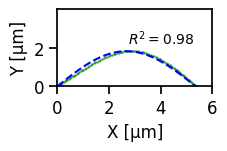

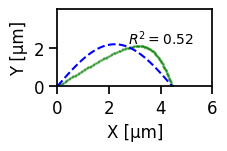

In [ ]:
coefficient_det=[]
Sp_name=[]

for i in range(3,5): ## this is the loop on the Spindles
    if i in Excluded: #Add exclude not well imaged spindles from the analysis
            continue
    data=pd.read_csv('%s%s/sp%s.csv'%(loc,i,i))
    y_path_1=data["Y"]
    x_path_1=data["X"]

    ## Figures position
    a4_dims = (2,1)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set_context("notebook", font_scale=1.5)

    ## Rotate the data using the angle between the first and last point
    x_path_2,y_path_2 = reverse(x_path_1,y_path_1)
    angle = np.arctan((y_path_2[0] - y_path_2[99]) / (x_path_2[0] - x_path_2[99]))
    x_path_3,y_path_3 = rotation(x_path_2,y_path_2,angle)
    x_path_4,y_path_4 = translation(x_path_3,y_path_3)
    x_path,y_path = flip(x_path_4,y_path_4)


    # Dataset
    x= np.asarray(x_path)
    y= np.asarray(y_path)
    # Plot
    plt.scatter(x,y, color='green',s=1,alpha=0.5,label='Spindle')

    ## Optimization polynomial fit using R2 as an indicator
    N=3 # start with a polynomial of degree 3
    R2=0

    while ((R2 <= 0.9999) and (N<=19)):
        xnew, ynew,z,R2=RegressionPoly(x,y,N)
        N=N+1
    else:
        print('optimization stopped for spindle:',i,',loop N:',N )


    #plt.axis("equal")
    plt.xlim([0,6])
    plt.ylim([0,4])

# Define the parameters
    D = xnew[len(xnew)-1] # Pole to Pole distance
    L = IntegralPoly(z, 0, xnew[len(xnew)-1]) # Desired arc length of y(x) between x=0 and x=D

# Find the root using scipy.optimize.root
    root_result = optimize.root(func, x0=0.0)

# Retrieve the value of Ym at the root
    Ym_root = root_result.x[0]

#print("Ym =", Ym_root)

    x_data = np.linspace(0, xnew[len(xnew)-1], 100)
    plt.plot(x_data, PerfectSpindle(x_data,D,Ym_root), 'b--',label='Beam Theory')

# Concatenate coefficient of determination between the perfect and real
    RR2 = r2_score(PerfectSpindle(x,D,Ym_root),y, sample_weight=None, multioutput='uniform_average')
    coefficient_det.append(RR2)

# Write RR2 on the figure
    plt.text(4, 2.2, r'$R^2 = %.2f$' % round(RR2, 2), fontsize=10, color='k', ha='center')


# Name of the spindle
    Sp_name.append(i)

    plt.xlabel('X [µm]',fontsize=12)
    plt.ylabel('Y [µm]',fontsize=12)


    # Major ticks, minor ticks for the figures
    x_ticks = np.arange(0, 8, 2)
    y_ticks = np.arange(0,3, 2)

    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    # Create a DataFrame containing the coordinates of the Beam theory bent spindle (Perf) and the Real one (Real) with same X coordinates
    df= pd.DataFrame(data={'X': x_data, 'Y': ynew, 'Y_Beam': PerfectSpindle(x_data,D,Ym_root)})

    ##Save coeff determination in DataFrame
df = pd.DataFrame(coefficient_det, columns=['R2'])
df['Sp']=pd.DataFrame(Sp_name)
